# Skipping Excel cells

It is often useful to be able to store extra content in Atomica framework files, databooks, and program books. However, this content must be placed carefully to avoid interfering with content read in and used by Atomica. To facilitate this, there are a number of safe places provided to users to enter extra data, with a combination of blank cells and cells containing the special keyword '#ignore' to flag when content should be skipped. 

## General principles

As a general rule, when parsing sheets in Atomica, content is split into 'tables' separated by blank lines. Once a blank row is reached, the table is considered complete, and further rows in the sheet will be grouped into a new table. The rows corresponding to each table are passed to the constructor for the relevant object being constructed. Therefore

1. The parsing of the spreadsheet into rectangular tables is handed by `excel.py:read_tables()`
2. The parsing of the rectangular tables into objects (such as `TimeDependentValuesEntry`) are handled by those specific classes. Methods such as `TimeDependentValuesEntry.from_rows()` accept as input the rows parsed by `read_tables()`

The number of columns present in each table is determined by `openpyxl` and generally spans the entire range of columns containing values in the workbook. The number of rows in the sheet is determined by `openpyxl` and spans the entire range of rows containing values in the workbook. Within this range of rows, tables are identified by 'blank' lines. A special keyword '#ignore' can be used to control parsing of the rows. This keyword behaves in the following ways depending on the position in the row:

1. If the first cell in the first column contains '#ignore' then the row will be skipped entirely. For this purpose, it is equivalent to deleting the row from Excel. The skipped row is NOT treated as a blank row, and will not interrupt parsing the table
2. If the row starts with blank cell(s), and then '#ignore' is the first value encountered, it will skip the row AND terminate parsing the table. The entire row is treated as blank for this purpose
3. If the row starts with content, the row will be retained regardless of whether or not '#ignore' subsequently appears in the row. In that case, '#ignore' will be retained in the table and handled by the code consuming the table

## Frameworks

For framework files, within each row, if a '#ignore' is encountered, no further content in the row will be parsed. This is implemented via `excel.py:read_dataframes()`. Typically, the tabular structure of framework files lends itself to skipping entire rows by placing '#ignore' at the start of the row, so it is anticipated that more advanced usage of '#ignore' in framework files would not be a common use case. 

## Databooks

### TimeDependentConnections

For transfers and interactions, there are three tables that are ready by each `TimeDependentConnections` instance.

The first table contains metadata for the transfer or interaction. This table is expected to contain only two rows - a heading row, and a single row of data. The table is parsed based on headings, where any columns containing a heading will be read, until a '#ignore' is reached in the first row. Rows below the table will be ignored. 


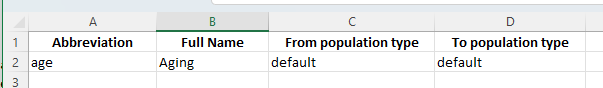

As shown in the example below

- Cell E2 is ignored because E1 is empty
- Row 3 is ignored because only the first row is read
- Column G and all further columns are ignored because of the '#ignore' in G1
- The extra attribute in column F _will_ be read, because the empty cell in E1 does not terminate parsing

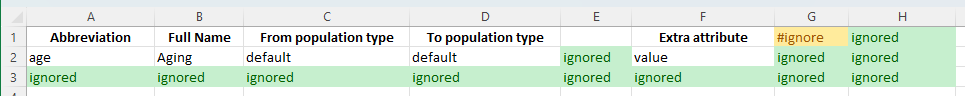

The second table contains a Y/N matrix enabling or disabling data entry rows for each cross-population term. In this table, only the first row and first column are parsed, as the rest of the content in the table is inferred from the rows present in the table immediately below this one. A '#ignore' in the top row will terminate parsing of that row. A '#ignore' in the first column causes the entire row to be skipped prior to the table parsing routine commencing. 

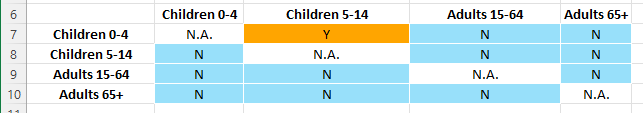

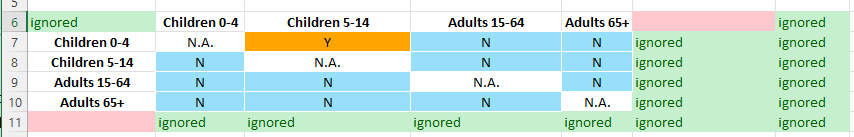

The final table consists of the actual time series data entries. This table is parsed in two steps

1. The header row is parsed to determine which columns to read
2. All subsequent rows are parsed based on the identified headings

As shown in the example below, blank cells are permitted in the header row. These cells are simply skipped over. Any cells in the header row with a numeric value are treated as time points. The row is parsed from left to right, so if duplicate values are present, the rightmost column will end up being used. A '#ignore' can be entered in the heading row to stop parsing. Subsequent columns will be ignored _for the rest of the table_. 
Similarly, any values in the main table that do not have a header entry will also be ignored. This means that 

1. Any cells to the right of the header will be ignored by default, in any of the data entry rows
2. Any cells to the right of a '#ignore' _including_ those in the header will also be ignored

A '#ignore' present inside the data entry rows will be _preserved_ assuming that the column has otherwise not been ignored.

Here are some examples of this. In this example, the block of cells on the right will be ignored, because there is no header entry, and therefore they will not be parsed

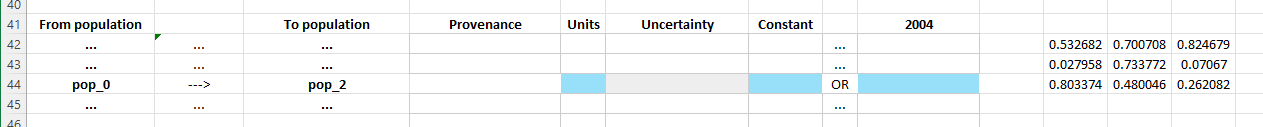

These cells will be _used_ because blank header columns are permitted, so the empty cell after '2004' does not terminate parsing

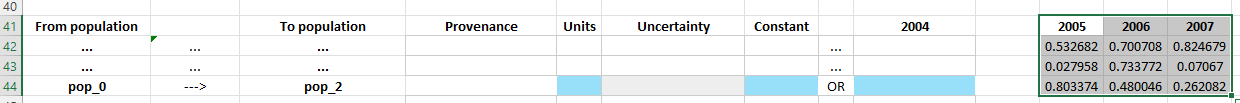

These cells will be ignored, because there is a preceding header row containing '#ignore' which terminates parsing of the header. Because the header row has been ignored, the remaining rows do not all individually need '#ignore' entries, although it would be harmless to provide them because all of the cells below '#ignore' will also be ignored

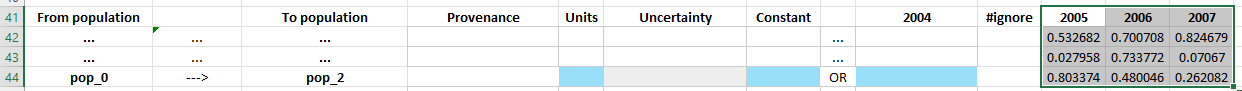

### TimeDependentValuesEntry

Data entry for standard framework quantities via `TimeDependentValuesEntry` tables follows the same logic as the time series content in `TimeDependentConnections`. That is

1. Columns to parse are based on the header row. Empty cells in the header row will skip any entries in that column. Parsing can be terminated with a '#ignore' cell
2. Rows with a blank cell in the first column will be skipped

Similarly to `TimeDependentConnections`, tables in the databook are separated by blank rows. But as described above, a row containing blank cells and then a '#ignore' will be treated as a blank row rather than skipped. For example, consider the following sheet:

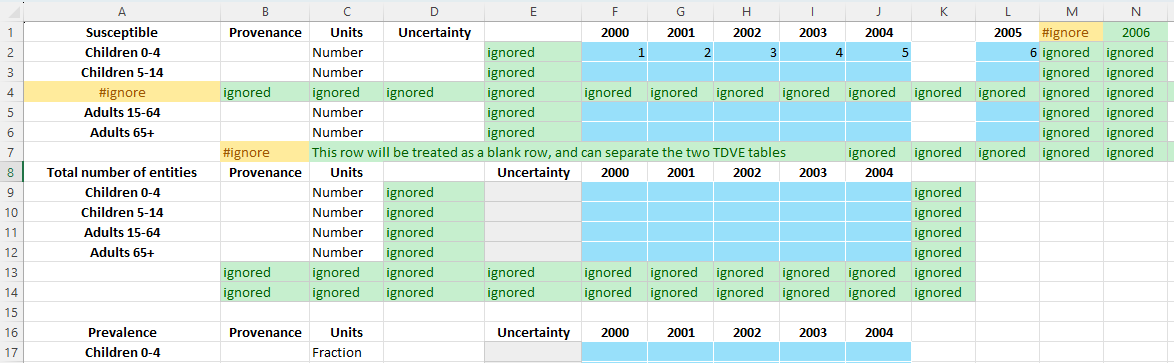


There are three tables, 'Susceptible', 'Total number of entities', and 'Prevalence'. Row 4 starts with '#ignore' and therefore the row is skipped entirely. This does _not_ split the 'Susceptible' table, and hence rows 5 and 6 are treated as belonging to the 'Susceptible' table. In contrast, row 7 contains a blank cell in column A, and '#ignore' in column B. Therefore, row 7 is treated as being equivalent to a blank row, and so it _does_ separate the 'Susceptible' table and the 'Total number of entities' table. Finally, rows 13 and 14 contain blank cells in column A, but they do _not_ contain a '#ignore'. Therefore, rows 13 and 14 are considered to be part of the 'Total number of entities' table. However, because rows 13 and 14 start with blank cells, they will not be read by the table parsing routine, and so the content in those rows will be ignored. 

Note that if cell B7 was replaced with the string 'ignored', parsing would fail, because then this sheet would be treated as one big table, rather than two small tables i.e., the parsing routine would not be able to detect where the 'Total number of entities' table began. Indeed, since rows 13 and 14 do not contain '#ignore', the blank line on row 15 is required to separate the 'Total number of entities' table from the 'Prevalence' table. 

Lastly, '#ignore' entries should not appear in the middle of the spreadsheet, underneath a valid heading. For example, on row 2, they should not appear in columns B:D (because column A has content, and columns B:D have non-empty headings), nor in columns F:J or L. 

The other features described above are also demonstrated here. Column E in the 'Susceptible' table is ignored, because cell E1 is empty. Columns M and N are both ignored in the 'Susceptible' table because of the '#ignore' in cell M1. Column L is still read in and used despite cell K1 being empty, because empty header cells do not terminate parsing. 

In practice, the simplest use case may be to simply add a column of '#ignore' cells off to the right of the data entry tables, and then any arbitrary content could be placed further to the right. For example:

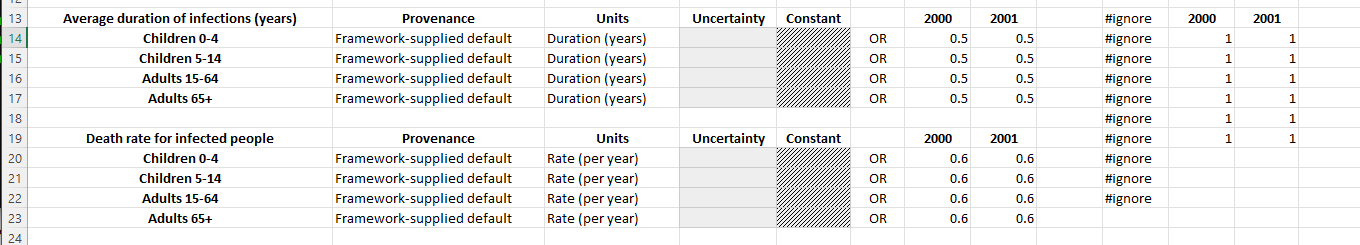

## Program books


### Program targeting

The program targeting sheet supports only minimal comments. *'#ignore' cells within the targeting table are not supported*. Extra content can be placed on this sheet below the main table, after a blank row (noting that a row with blank cells followed by a '#ignore' will still be processed by the table parsing routine, and such rows will be treated as blank prior to actual program book parsing). Safe regions for comments are indicated below:

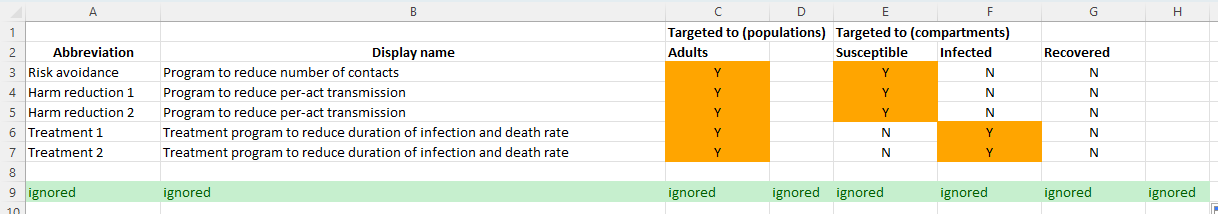




### Spending data 

The spending data sheet consists of `TimeDependentValuesEntry` tables the same as the databook. Therefore the same functionality around '#ignore' applies as described above for databooks.

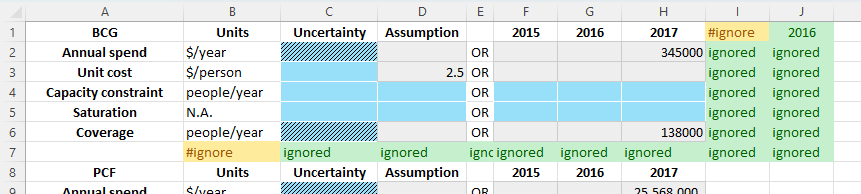

### Program effects

The program effects sheet follows much the same logic as the `TimeDependentValuesEntry`, with parsing driven by the heading rows, and '#ignore' terminating parsing of the header

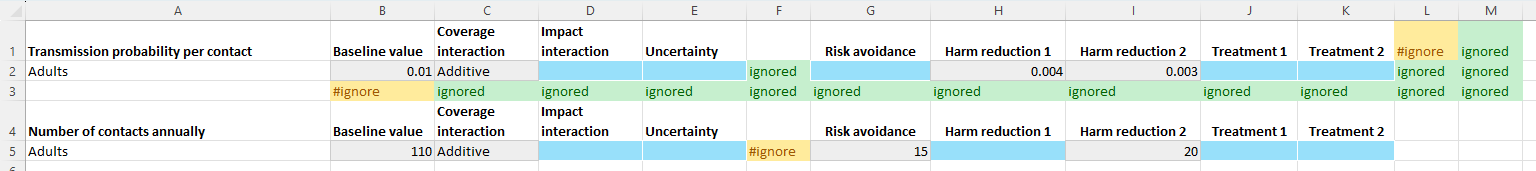



Note that because '#ignore' within the table content is only parsed in the heading row, subsequent '#ignore' entries have no effect (unless occuring in the first row, or as the leading non-empty cell, which is handled by the table parsing routine prior to constructing the `ProgramSet`). So in the example above, the '#ignore' in cell F5 does not have any effect, and the values in G5:K5 will still be read in. Further, a '#ignore' in cell H5 would raise an error because H5 needs to contain a numerical value. 